In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

_ = torch.manual_seed(42)

# Create useful directories
We will first create all useful directories used to store figures, datas and models

In [2]:
!mkdir -p ../data
!mkdir -p ../figures
!mkdir -p ../models

# Helper functions

Here are the implementation of some usefull functions

In [3]:
def saveModel(model, model_name, date=True):    
    if date: filename = f'..Models/{model_name}_{datetime.now().strftime("%Y_%m_%d__%H_%M")})'
    else: filename = f'..Models/{model_name}'
    
    torch.save(model.state_dict(), filename)

In [4]:
def loadModel(model, model_name):
    model.load_state_dict(torch.load(f'./Models/{model_name}'))
    model.eval()
    return model

In [5]:
def showimgpanel(imgs, n_imgs, panelshape, figsize=(15,15), 
                 labels=None, labels_prefix="Label : ",
                 title="", fontsize_title=30, fontsize_label=15, 
                 savefig=True, savedir=None):
    x,y = panelshape
    n_imgs = min(imgs.shape[0], n_imgs, x*y)
    
    fig = plt.figure(figsize = figsize)
    fig.suptitle(title, fontsize = fontsize_title)
    fig.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(n_imgs):
        ax = fig.add_subplot(x, y, i+1)
        img = imgs[i]
        
        if labels is None: label = ''
        else: label = labels_prefix + str(int(labels[i]))
        
        showimg(img, ax, title=label, fontsize=fontsize_label, savefig=False)            
        
    if savefig and filename is not None: plt.savefig(f"{savedir}{title}.png")
    

In [6]:
# Divide dataset into batches

def divideInBatches(dataset, batch_size):
    # Train set
    n_batches = np.ceil(len(dataset)/batch_size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader, n_batches,

In [7]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [8]:
def showimg(img, ax=None, shape=(28, 28), cmap='plasma', title="", fontsize=15, axis=False, savefig=True, savedir=None):
    if ax is None: _, ax = plt.subplots()
    if not axis: ax.axis('off')
        
    img = img.reshape(shape)
    ax.imshow(img, cmap=cmap)
    ax.set_title(title, fontsize=fontsize)
    
    if savefig and filename is not None: plt.savefig(f"{filename}{savedir}.png")

In [9]:
device = chooseDevice()

GPU available via cuda


# Custom dataset class
As we will transform the initial dataset, we are going to use custom classes to store the dataset so the workflow stays the same throughout the notebook

In [10]:
class ReducedFashionMNISTDataset(Dataset):
    """
    Custom reduced dataset class for workflow logic
    """
    
    def __init__(self, data, target, classes):
        """
        Args:
            data (tensor): The data
            target (tensor): The target class of the data
            classes (string list): Ordered list of the classes represented by target
        """
        self.data = data
        self.target = target
        self.classes = classes
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idc.tolist()
        return (self.data[idx], self.labels[ids],)
    
    def __repr__(self):
        return f'Dataset Reduced FashionMNIST\n    Number of datapoints: {self.__len__()}'
    
    def __str__(self):
        return self.__repr__()

# Define datasets
We first download the fashionMNIST dataset using the dataset module of the pytorch library.
Then we reduce the model to 20% of its original size to have a lowerbound for our data augmentation performances.

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

test_set = torchvision.datasets.FashionMNIST(root="../data/", train=False, download=True, transform=transform)
test_set_size = len(test_set)

full_train_set = torchvision.datasets.FashionMNIST(root="../data/", train=True, download=True, transform=transform)
full_train_set_size = len(full_train_set)

In [12]:
reduction_factor = 0.05

idxs = np.random.choice(np.arange(full_train_set_size), int(full_train_set_size*reduction_factor) ,replace=False)

# Normalize the data from [-1. to 1.]
reduced_data  = full_train_set.data[idxs].float()
reduced_data /= reduced_data.max() - reduced_data.min()
reduced_data  = 2. * reduced_data - 1.

reduced_labels = full_train_set.targets[idxs]

In [13]:
reduced_train_set = torch.utils.data.TensorDataset(reduced_data, reduced_labels) #ReducedFashionMNISTDataset(reduced_data, reduced_labels, full_train_set.classes)

In [14]:
# Delete some, now, useless variables
del reduction_factor, idxs, reduced_data, reduced_labels

In [15]:
batch_size = 32

In [16]:
# Create base loader
full_train_loader,    full_train_n_batches    = divideInBatches(full_train_set, batch_size)
reduced_train_loader, reduced_train_n_batches = divideInBatches(reduced_train_set, batch_size)
test_loader,          test_n_batches          = divideInBatches(test_set, batch_size)

# Model definition
Here we will define the architecture of our models

## CNN model

In [19]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

# Training of the CNN

In [20]:
n_epoch_cnn = 5
n_classes = len(full_train_set.classes)

In [21]:
def computeCNNAccuracy(y_predicted,y_true):
    accuracy = 0.0
    accuracy = torch.sum(y_predicted == y_true).item()/y_true.shape[0]
    return accuracy

In [22]:
def evaluate_raw_performances(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
                              losses_train, accuracies_train, accuracies_test, 
                              loss_function, optimizer):
    cnn.eval()
    for batch_id, (data, labels) in enumerate(train_loader):
        data = data.reshape((-1,1,28,28))
        data = data.to(device)
        labels = labels.to(device)

        pred = cnn(data)

        labels_pred, labels_prob, _ = cnn.predictLabels(pred)

        target_prob = torch.zeros_like(labels_prob)
        for i,j in enumerate(labels):
            target_prob[i][j] = 1
        target_prob = target_prob.to(device)

        loss = loss_function(labels_prob, target_prob)
        
        optimizer.zero_grad()
        
        losses_train[0] += loss.item()
        accuracies_train[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_train[0] /= train_n_batches
    losses_train[0] /= train_n_batches

    cnn.eval()
    for batch_id, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        pred = cnn(data)

        labels_pred, _, _ = cnn.predictLabels(pred)

        accuracies_test[0] += computeCNNAccuracy(labels_pred, labels)

    accuracies_test[0] /= test_n_batches

    print(f"Accuracy during training: {accuracies_train[0]*100:.2f}%")
    print(f"Accuracy during test:     {accuracies_test[0]*100:.2f}%")
    print(f"Loss during training:     {losses_train[0]:.2f}")

In [23]:
def train_cnn(cnn, train_loader, test_loader, train_n_batches, test_n_batches,
              losses_train, accuracies_train, accuracies_test, 
              loss_function, optimizer, n_epoch):
    # Training of the CNN
    for epoch in range(n_epoch):
        cnn.train()
        for batch_id, (data, labels) in enumerate(train_loader):
            data = data.reshape((-1,1,28,28))
            data = data.to(device)
            labels = labels.to(device)

            pred = cnn(data)

            labels_pred, labels_prob, _ = cnn.predictLabels(pred)

            target_prob = torch.zeros_like(labels_prob)
            for i,j in enumerate(labels):
                target_prob[i][j] = 1
            target_prob = target_prob.to(device)

            loss = loss_function(labels_prob, target_prob)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_train[epoch + 1] += loss.item()
            accuracies_train[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_train[epoch + 1] /= train_n_batches
        losses_train[epoch + 1] /= train_n_batches

        cnn.eval()
        for batch_id, (real, labels) in enumerate(test_loader):
            real = real.to(device)
            labels = labels.to(device)
            pred = cnn(real)

            labels_pred, _, _ = cnn.predictLabels(pred)

            accuracies_test[epoch + 1] += computeCNNAccuracy(labels_pred, labels)

        accuracies_test[epoch + 1] /= test_n_batches

        print(f"Epoch [{epoch + 1:2d}/{n_epoch:2d}] \
                Accuracy: {accuracies_test[epoch + 1]:.4f} \
                Loss:     {losses_train[epoch + 1]:.4f}")

## Train CNN on full data set

In [24]:
cnn_full = CNN(n_classes).to(device=device)

In [25]:
# Loss function for the CNN
loss_function_cnn_full = nn.CrossEntropyLoss()

In [26]:
# Adam optimization parameters
lr_cnn_full = 0.001
betas_cnn_full = (0.9, 0.999)

optimizer_cnn_full = torch.optim.Adam(cnn_full.parameters(), lr=lr_cnn_full, betas = betas_cnn_full)

In [27]:
%%time

# Error metrics at initialisation

losses_train_cnn_full     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_full = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_full  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
                          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
                          loss_function_cnn_full, optimizer_cnn_full)
print()

Accuracy during training: 10.02%
Accuracy during test:     10.01%
Loss during training:     2.35

CPU times: user 14.3 s, sys: 313 ms, total: 14.6 s
Wall time: 14.6 s


In [28]:
%%time
train_cnn(cnn_full, full_train_loader, test_loader, full_train_n_batches, test_n_batches,
          losses_train_cnn_full, accuracies_train_cnn_full, accuracies_test_cnn_full, 
          loss_function_cnn_full, optimizer_cnn_full,n_epoch_cnn)

print()

Epoch [ 1/ 5]                 Accuracy: 0.8787                 Loss:     1.6409
Epoch [ 2/ 5]                 Accuracy: 0.8875                 Loss:     1.5791
Epoch [ 3/ 5]                 Accuracy: 0.8928                 Loss:     1.5663
Epoch [ 4/ 5]                 Accuracy: 0.8950                 Loss:     1.5579
Epoch [ 5/ 5]                 Accuracy: 0.9011                 Loss:     1.5525

CPU times: user 1min 29s, sys: 199 ms, total: 1min 29s
Wall time: 1min 29s


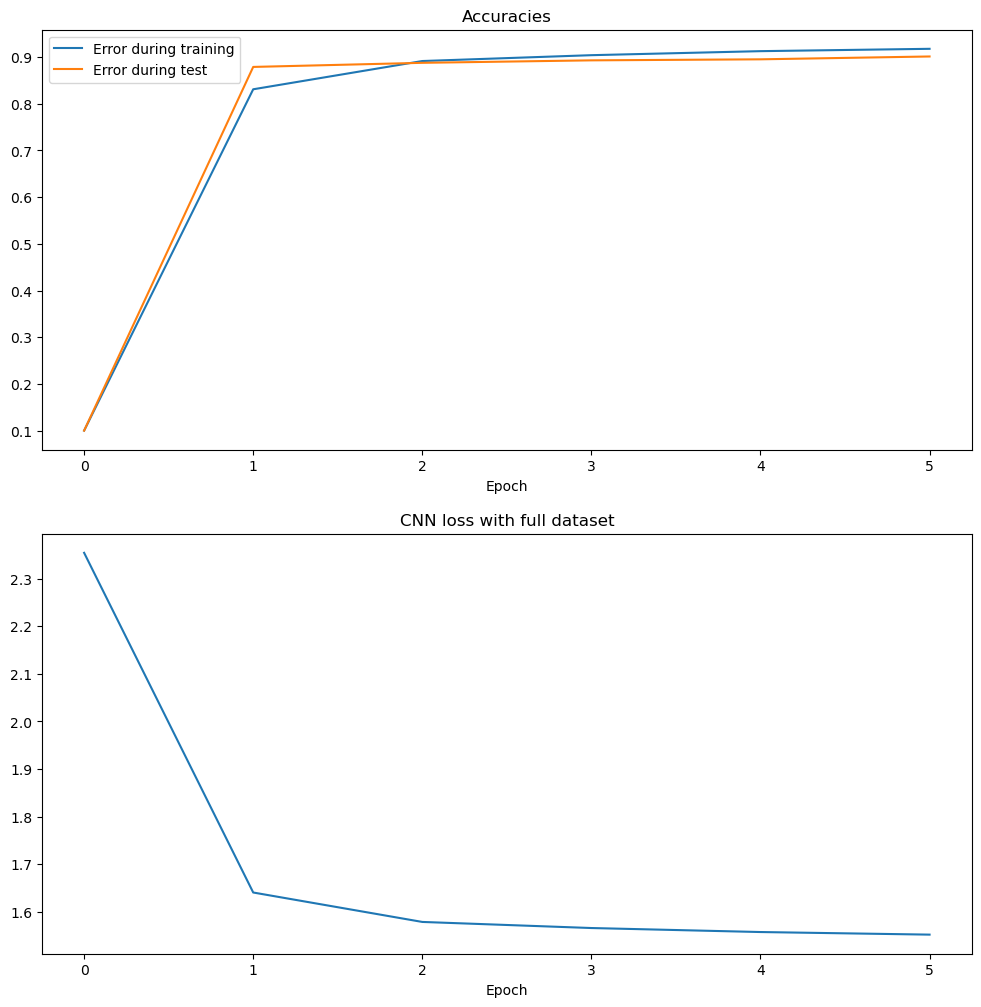

In [29]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn_full, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn_full, label = "Error during test")
ax1.set_title('Accuracies')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn_full)
ax2.set_title('CNN loss with full dataset')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#plt.savefig("../figures/CNN_Metrics.png")

In [30]:
# Delete some, now, useless variables
del loss_function_cnn_full, lr_cnn_full, betas_cnn_full, optimizer_cnn_full

## Train CNN on reduced data set

In [31]:
cnn_reduced = CNN(n_classes).to(device=device)

In [32]:
# Loss function for the CNN
loss_function_cnn_reduced = nn.CrossEntropyLoss()

In [33]:
# Adam optimization parameters
lr_cnn_reduced = 0.001
betas_cnn_reduced = (0.9, 0.999)

optimizer_cnn_reduced = torch.optim.Adam(cnn_reduced.parameters(), lr=lr_cnn_reduced, betas = betas_cnn_reduced)

In [34]:
%%time

# Error metrics at initialisation

losses_train_cnn_reduced     = np.zeros(n_epoch_cnn+1)
accuracies_train_cnn_reduced = np.zeros(n_epoch_cnn+1)
accuracies_test_cnn_reduced  = np.zeros(n_epoch_cnn+1)

evaluate_raw_performances(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
                          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
                          loss_function_cnn_reduced, optimizer_cnn_reduced)

print()

Accuracy during training: 5.33%
Accuracy during test:     5.71%
Loss during training:     2.37

CPU times: user 1.99 s, sys: 4.01 ms, total: 1.99 s
Wall time: 2 s


In [35]:
%%time
train_cnn(cnn_reduced, reduced_train_loader, test_loader, reduced_train_n_batches, test_n_batches,
          losses_train_cnn_reduced, accuracies_train_cnn_reduced, accuracies_test_cnn_reduced, 
          loss_function_cnn_reduced, optimizer_cnn_reduced,n_epoch_cnn)

print()

Epoch [ 1/ 5]                 Accuracy: 0.7541                 Loss:     1.8942
Epoch [ 2/ 5]                 Accuracy: 0.8074                 Loss:     1.6819
Epoch [ 3/ 5]                 Accuracy: 0.8269                 Loss:     1.6322
Epoch [ 4/ 5]                 Accuracy: 0.8162                 Loss:     1.6102
Epoch [ 5/ 5]                 Accuracy: 0.8445                 Loss:     1.5907

CPU times: user 10.5 s, sys: 8.85 ms, total: 10.5 s
Wall time: 10.6 s


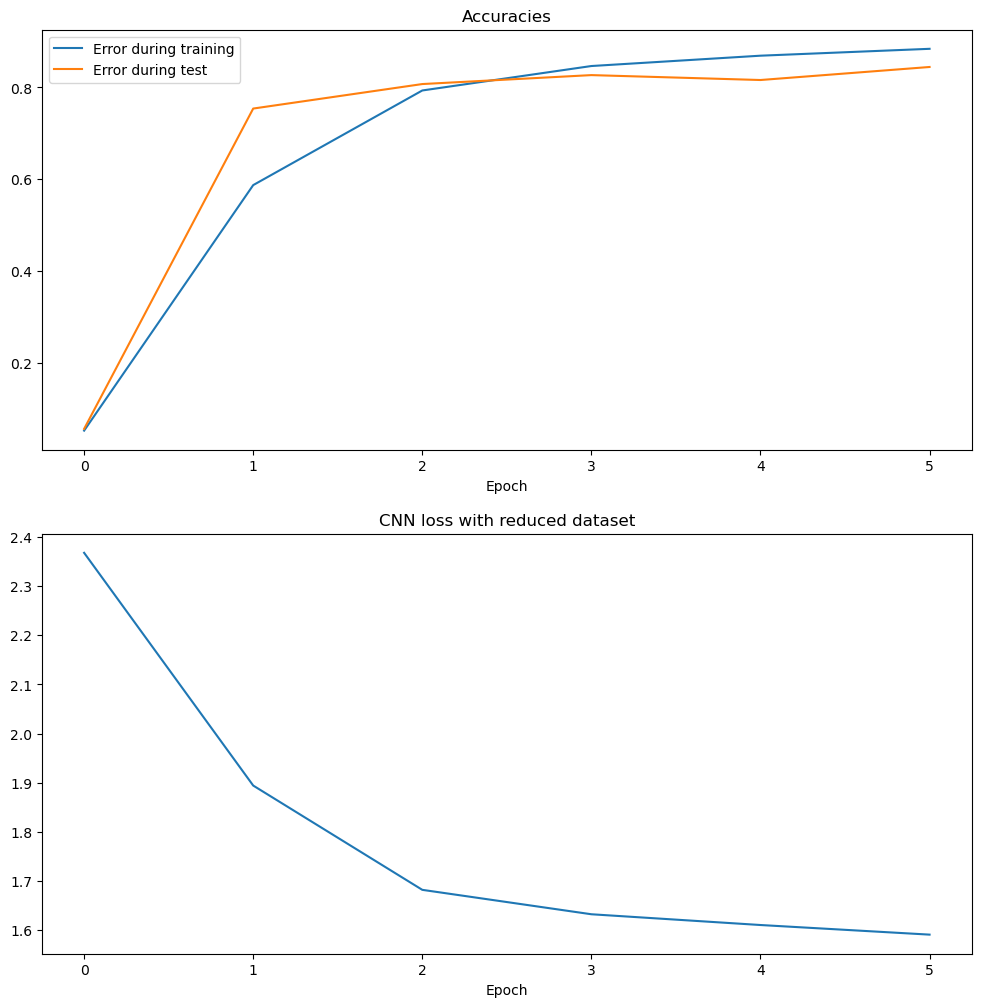

In [36]:
# Plots of accuracy and of loss function, images generated from your reference sample.
epochs = np.arange(n_epoch_cnn+1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

ax1.plot(epochs, accuracies_train_cnn_reduced, label = "Error during training")
ax1.plot(epochs, accuracies_test_cnn_reduced, label = "Error during test")
ax1.set_title('Accuracies')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(epochs, losses_train_cnn_reduced)
ax2.set_title('CNN loss with reduced dataset')
ax2.set_xlabel('Epoch')


for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

#plt.savefig("../figures/CNN_Metrics.png")

In [37]:
# Delete some, now, useless variables
del loss_function_cnn_reduced, lr_cnn_reduced, betas_cnn_reduced, optimizer_cnn_reduced